In [1216]:
import tweepy
import pandas as pd
import configparser
import re
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

In [1217]:
config = configparser.ConfigParser()
config.read("config.ini")

['config.ini']

In [1218]:
api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

In [1219]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [1220]:
#posts = tweepy.Cursor(api.user_timeline, screen_name="ArvindKejriwal", count = 200, tweet_mode="extended").items((300))

In [1221]:
posts = tweepy.Cursor(api.search_tweets, q="#bitcoin", count = 200, lang ="en", tweet_mode="extended").items((100))

In [1222]:
df = pd.DataFrame([tweet.full_text for tweet in posts], columns=['Tweets'])

In [1223]:
df

,Tweets
0,@BluesparrowC @davidgokhshtein @BlueSparrowETH...
1,A very big thankyou to @Tradeosiann for givi...
2,RT @VinuSquad: 50$ GIVEAWAY | 12 HOURS \n\n-Fo...
3,RT @Jayecane: Sent you money #Bitcoin @sneadcx...
4,A very big thankyou to @Tradeosiann for givi...
...,...
95,RT @BTC_Archive: 💥US Senator Ted Cruz owns #Bi...
96,Working on yourself is the best investment. Ju...
97,RT @VinuSquad: 50$ GIVEAWAY | 12 HOURS \n\n-Fo...
98,RT @hellboycrypto1: A coffee is better if it i...


In [1224]:
def extract(text):
    text = re.findall("(@[A-Za-z0–9\d\w]+)", text)
    return text

df["mention"] = df["Tweets"].apply(extract)


In [1225]:
df['links'] = df['Tweets'].str.extract('(https?:\/\/\S+)', expand=False).str.strip()
df['retweets'] = df['Tweets'].str.extract('(RT[\s@[A-Za-z0–9\d\w]+)', expand=False).str.strip()

In [1226]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [1227]:
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    text = re.sub("\n","",text) 
    text = re.sub(":","",text) 
    text = re.sub("_","",text) 
    text = emoji_pattern.sub(r'', text)
    return text


# Clean the tweets
df['Tweets'] = df['Tweets'].apply(cleanTxt)
df['retweets'] = df['retweets'].str.replace(r"(RT )", "")
discard = ["CNFTGiveaway", "IVEAWAYPrizes", "Giveaway", "Airdrop", "GIVEAWAY"]
df = df[~df["Tweets"].str.contains('|'.join(discard))]

<ipython-input-1227-f37e1099dc1f>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['retweets'] = df['retweets'].str.replace(r"(RT )", "")


In [1228]:
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df

<ipython-input-1228-d444dd8f48c6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
<ipython-input-1228-d444dd8f48c6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'] = df['Tweets'].apply(getPolarity)


,Tweets,mention,links,retweets,Subjectivity,Polarity
0,When BlueSparrow take a handful and invite ...,"[@BluesparrowC, @davidgokhshtein, @BlueSparrow...",NaN,NaN,0.550000,0.575000
1,A very big thankyou to for giving me tip ab...,[@Tradeosiann],NaN,NaN,0.476667,0.116667
3,Sent you money Bitcoin who’s next ?? rt + done,"[@Jayecane, @sneadcxr]",NaN,@Jayecane,0.000000,0.000000
4,A very big thankyou to for giving me tip ab...,[@Tradeosiann],NaN,NaN,0.476667,0.116667
7,wolf2020 Archive Are you tired of scam projec...,"[@spy_wolf2020, @BTC_Archive, @SpyWolfNetwork,...",https://t.co/UdMsRAHYUs,NaN,0.350000,-0.300000
...,...,...,...,...,...,...
94,A very big thankyou to for giving me tip ab...,[@Tradeosiann],NaN,NaN,0.476667,0.116667
95,Archive US Senator Ted Cruz owns Bitcoin Anoth...,[@BTC_Archive],NaN,@BTC_Archive,0.000000,0.000000
96,Working on yourself is the best investment. Ju...,[],NaN,NaN,0.594444,0.750000
98,1 A coffee is better if it is enjoyed in a TCO...,[@hellboycrypto1],NaN,@hellboycrypto1,0.600000,0.500000


In [1229]:
mention = pd.DataFrame(df["mention"].to_list()).add_prefix("mention_")
mention

,mention_0,mention_1,mention_2,mention_3
0,@BluesparrowC,@davidgokhshtein,@BlueSparrowETH,@BlueSparrowETH
1,@Tradeosiann,None,None,None
2,@Jayecane,@sneadcxr,None,None
3,@Tradeosiann,None,None,None
4,@spy_wolf2020,@BTC_Archive,@SpyWolfNetwork,@SpyWolfNetwork
...,...,...,...,...
68,@Tradeosiann,None,None,None
69,@BTC_Archive,None,None,None
70,None,None,None,None
71,@hellboycrypto1,None,None,None


In [1230]:
def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'
    
df['Analysis'] = df['Polarity'].apply(getAnalysis)
# Show the dataframe
df.head(60)

<ipython-input-1230-28bae245cd30>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Analysis'] = df['Polarity'].apply(getAnalysis)


,Tweets,mention,links,retweets,Subjectivity,Polarity,Analysis
0,When BlueSparrow take a handful and invite ...,"[@BluesparrowC, @davidgokhshtein, @BlueSparrow...",NaN,NaN,0.550000,0.575000,Positive
1,A very big thankyou to for giving me tip ab...,[@Tradeosiann],NaN,NaN,0.476667,0.116667,Positive
3,Sent you money Bitcoin who’s next ?? rt + done,"[@Jayecane, @sneadcxr]",NaN,@Jayecane,0.000000,0.000000,Neutral
4,A very big thankyou to for giving me tip ab...,[@Tradeosiann],NaN,NaN,0.476667,0.116667,Positive
7,wolf2020 Archive Are you tired of scam projec...,"[@spy_wolf2020, @BTC_Archive, @SpyWolfNetwork,...",https://t.co/UdMsRAHYUs,NaN,0.350000,-0.300000,Negative
8,Here's a glimpse of our Nft Game that we are ...,[@ShibaZuna],NaN,@ShibaZuna,0.400000,-0.400000,Negative
9,@bitcoiner BITCOIN mon 37 1337 btc,"[@_bitcoiner, @coinkit_]",https://t.co/RNXuIoXday,@_bitcoiner,0.000000,0.000000,Neutral
10,Banks closed. Stock Market closed. Bitcoin open.,[@DocumentingBTC],NaN,@DocumentingBTC,0.233333,-0.066667,Negative
11,Baby Bali babybalibsc BabyBaliArmy Bali ElonM...,[@BitMEX],https://t.co/Ybr0ECTFmx,NaN,0.000000,0.000000,Neutral
12,The best 1000x NFT token is bluesparrowWhy?KY...,"[@kucoincom, @BlueSparrowETH]",https://t.co/ulux1XSuzP,NaN,0.766667,0.458333,Positive


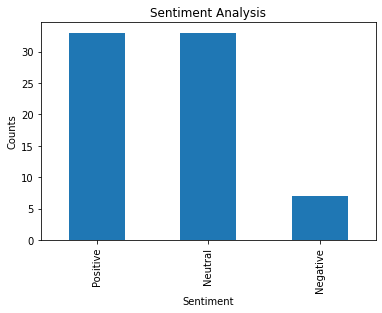

In [1231]:


# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

